# Table of Contents:
1. [Import Libraries](#Import-Libraries)
2. [Load Data](#Load-Data)
3. [Preprocess Data](#Preprocess-Data)
4. [Train/Predict/Evaluate the Model](#Train/Predict/Evaluate-the-Model)
5. [Examples](#Examples)

# Import Libraries

In [ ]:
import os
import numpy as np
import pandas as pd

import keras
import tensorflow as tf
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam

print(keras.__version__)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import seaborn as sns

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

font      = {'family':'arial', 'style':'normal', 'size':18}
axis_font = {'family':'arial', 'style':'normal', 'size':18}
plt.rc('font', **font)

2.8.0


# Load Data

In [ ]:
data_dir = 'data'
dataset_weather = os.path.join(data_dir, 'Weather.csv')
dataset_climate = os.path.join(data_dir, 'AICU/GreenhouseClimate.csv')
df_weather = pd.read_csv(dataset_weather)
df_climate = pd.read_csv(dataset_climate,low_memory=False)
print(df_weather.columns)
print(df_climate.columns)

Index(['%time', 'dt', 'AbsHumOut', 'Iglob', 'PARout', 'Pyrgeo', 'RadSum',
       'Rain', 'Rhout', 'Tout', 'Winddir', 'Windsp'],
      dtype='object')
Index(['%time', 'AssimLight', 'BlackScr', 'CO2air', 'Cum_irr', 'EC_drain_PC',
       'EnScr', 'HumDef', 'PipeGrow', 'PipeLow', 'Rhair', 'Tair', 'Tot_PAR',
       'Tot_PAR_Lamps', 'VentLee', 'Ventwind', 'assim_sp', 'assim_vip',
       'co2_dos', 'co2_sp', 'co2_vip', 'dx_sp', 'dx_vip', 'int_blue_sp',
       'int_blue_vip', 'int_farred_sp', 'int_farred_vip', 'int_red_sp',
       'int_red_vip', 'int_white_sp', 'int_white_vip', 'pH_drain_PC',
       'scr_blck_sp', 'scr_blck_vip', 'scr_enrg_sp', 'scr_enrg_vip',
       't_grow_min_sp', 't_grow_min_vip', 't_heat_sp', 't_heat_vip',
       't_rail_min_sp', 't_rail_min_vip', 't_vent_sp', 't_ventlee_vip',
       't_ventwind_vip', 'water_sup', 'water_sup_intervals_sp_min',
       'water_sup_intervals_vip_min', 'window_pos_lee_sp',
       'window_pos_lee_vip'],
      dtype='object')


In [ ]:
df = pd.concat(
    [
        df_weather["%time"],
        df_weather["dt"],
        df_weather["Tout"],
        df_weather["Rhout"],
        df_weather["Iglob"],
        df_weather["Windsp"],
        df_climate["Tair"],
        df_climate["Rhair"],
        df_climate["CO2air"]
    ],
    axis=1,
)
print(df.shape)
df

(47809, 9)


,%time,dt,Tout,Rhout,Iglob,Windsp,Tair,Rhair,CO2air
0,43815.00000,12/16/2019 0:00,6.9,80.6,0.0,4.7,21.0,51.9,509
1,43815.00347,12/16/2019 0:05,6.9,80.6,0.0,4.7,21.5,51.3,484
2,43815.00694,12/16/2019 0:10,6.9,80.4,0.0,4.7,21.6,52.2,475
3,43815.01042,12/16/2019 0:15,6.9,80.2,0.0,4.7,21.3,54.6,501
4,43815.01389,12/16/2019 0:20,6.7,80.9,0.0,4.7,21.4,54.4,487
...,...,...,...,...,...,...,...,...,...
47804,43980.98611,5/29/2020 23:40,15.1,71.4,0.0,4.3,18.0,86.1,479
47805,43980.98958,5/29/2020 23:45,15.0,71.5,0.0,4.3,17.9,86.5,485
47806,43980.99306,5/29/2020 23:50,15.0,70.8,0.0,3.8,17.9,86.9,465
47807,43980.99653,5/29/2020 23:55,15.0,71.0,0.0,3.8,17.9,87.2,470


# Preprocess Data

In [ ]:
df = df.dropna().reset_index(drop=True)
df['dt'] = pd.to_datetime(df["dt"])
df.iloc[:,2:]=df.iloc[:,2:].apply(pd.to_numeric)
df

,%time,dt,Tout,Rhout,Iglob,Windsp,Tair,Rhair,CO2air
0,43815.00000,2019-12-16 00:00:00,6.9,80.6,0.0,4.7,21.0,51.9,509
1,43815.00347,2019-12-16 00:05:00,6.9,80.6,0.0,4.7,21.5,51.3,484
2,43815.00694,2019-12-16 00:10:00,6.9,80.4,0.0,4.7,21.6,52.2,475
3,43815.01042,2019-12-16 00:15:00,6.9,80.2,0.0,4.7,21.3,54.6,501
4,43815.01389,2019-12-16 00:20:00,6.7,80.9,0.0,4.7,21.4,54.4,487
...,...,...,...,...,...,...,...,...,...
47733,43980.98264,2020-05-29 23:35:00,15.2,71.8,0.0,4.3,18.0,85.6,459
47734,43980.98611,2020-05-29 23:40:00,15.1,71.4,0.0,4.3,18.0,86.1,479
47735,43980.98958,2020-05-29 23:45:00,15.0,71.5,0.0,4.3,17.9,86.5,485
47736,43980.99306,2020-05-29 23:50:00,15.0,70.8,0.0,3.8,17.9,86.9,465


findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


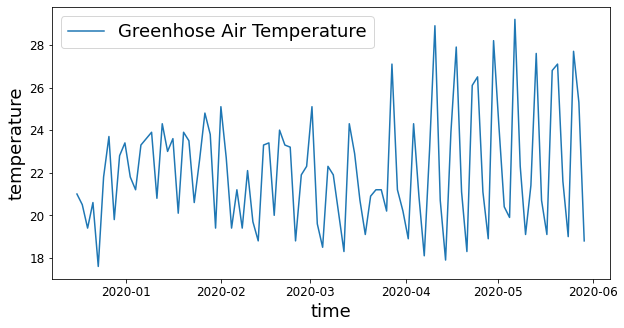

In [ ]:
fig = plt.figure(figsize=(10, 5))
plt.plot(df["dt"].iloc[::500], df["Tair"].iloc[::500], label='Greenhose Air Temperature')
plt.xlabel("time", axis_font)
plt.ylabel("temperature", axis_font)
plt.legend()

plt.show()

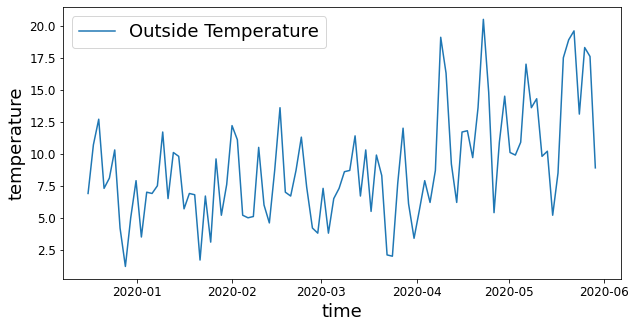

In [ ]:
fig = plt.figure(figsize=(10, 5))
plt.plot(df["dt"].iloc[::500], df["Tout"].iloc[::500], label='Outside Temperature')
plt.xlabel("time", axis_font)
plt.ylabel("temperature", axis_font)
plt.legend()

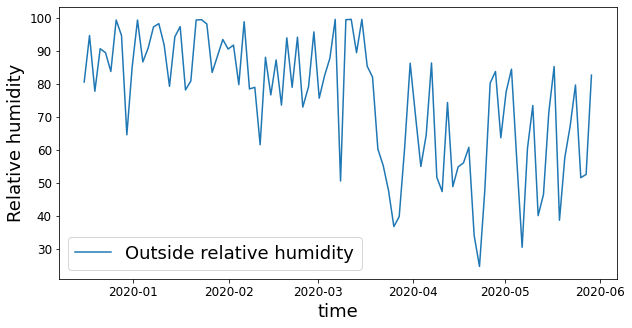

In [ ]:
fig = plt.figure(figsize=(10, 5))
plt.plot(df["dt"].iloc[::500], df["Rhout"].iloc[::500], label='Outside relative humidity')
plt.xlabel("time", axis_font)
plt.ylabel("Relative humidity", axis_font)
plt.legend()

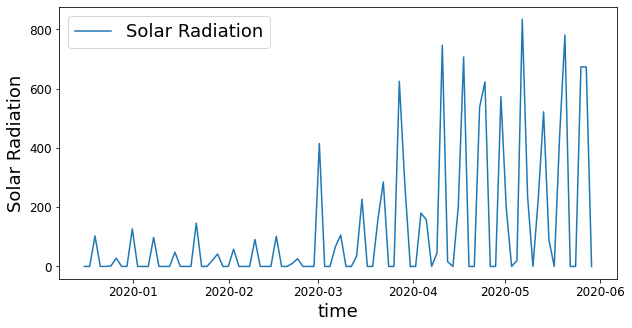

In [ ]:
fig = plt.figure(figsize=(10, 5))
plt.plot(df["dt"].iloc[::500], df["Iglob"].iloc[::500], label='Solar Radiation')
plt.xlabel("time", axis_font)
plt.ylabel("Solar Radiation", axis_font)
plt.legend()

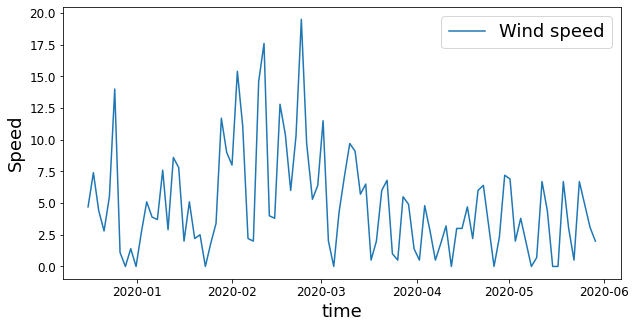

In [ ]:
fig = plt.figure(figsize=(10, 5))
plt.plot(df["dt"].iloc[::500], df["Windsp"].iloc[::500], label='Wind speed')
plt.xlabel("time", axis_font)
plt.ylabel("Speed", axis_font)
plt.legend()

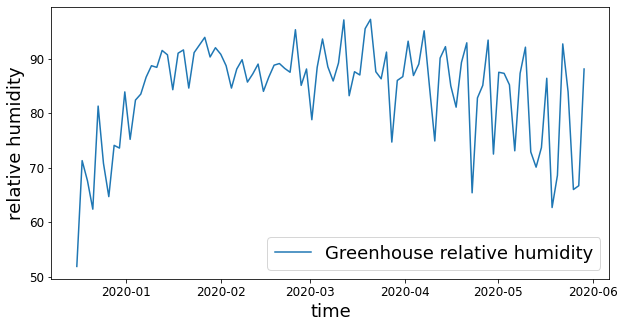

In [ ]:
fig = plt.figure(figsize=(10, 5))
plt.plot(df["dt"].iloc[::500], df["Rhair"].iloc[::500], label='Greenhouse relative humidity')
plt.xlabel("time", axis_font)
plt.ylabel("relative humidity", axis_font)
plt.legend()

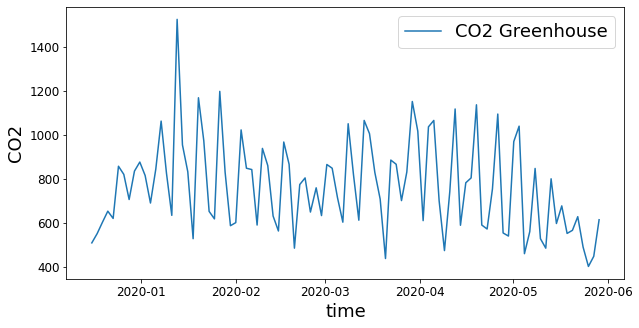

In [ ]:
fig = plt.figure(figsize=(10, 5))
plt.plot(df["dt"].iloc[::500], df["CO2air"].iloc[::500], label='CO2 Greenhouse')
plt.xlabel("time", axis_font)
plt.ylabel("CO2", axis_font)
plt.legend()

In [ ]:
n_train = int(df.shape[0] * 0.6)
n_val = int(df.shape[0] * 0.2)

df_normalized = df.copy()
df_normalized.iloc[:,2:] = df.iloc[:,2:].apply(lambda x: (x-x.iloc[:n_train].mean())/ x.iloc[:n_train].std(), axis=0)
df_normalized

,%time,dt,Tout,Rhout,Iglob,Windsp,Tair,Rhair,CO2air
0,43815.00000,2019-12-16 00:00:00,-0.133117,-0.336538,-0.457518,-0.309241,-0.256191,-4.370155,-1.645954
1,43815.00347,2019-12-16 00:05:00,-0.133117,-0.336538,-0.457518,-0.309241,-0.044735,-4.448084,-1.789053
2,43815.00694,2019-12-16 00:10:00,-0.133117,-0.351280,-0.457518,-0.309241,-0.002444,-4.331191,-1.840568
3,43815.01042,2019-12-16 00:15:00,-0.133117,-0.366022,-0.457518,-0.309241,-0.129317,-4.019475,-1.691746
4,43815.01389,2019-12-16 00:20:00,-0.210349,-0.314424,-0.457518,-0.309241,-0.087026,-4.045452,-1.771881
...,...,...,...,...,...,...,...,...,...
47733,43980.98264,2020-05-29 23:35:00,3.072010,-0.985190,-0.457518,-0.405498,-1.524929,0.006850,-1.932151
47734,43980.98611,2020-05-29 23:40:00,3.033394,-1.014674,-0.457518,-0.405498,-1.524929,0.071791,-1.817672
47735,43980.98958,2020-05-29 23:45:00,2.994778,-1.007303,-0.457518,-0.405498,-1.567220,0.123743,-1.783329
47736,43980.99306,2020-05-29 23:50:00,2.994778,-1.058901,-0.457518,-0.525820,-1.567220,0.175696,-1.897807


In [ ]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    index_column_temp = df_normalized.columns.get_loc("Tair")-2
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][index_column_temp]   # as index
        yield samples, targets

In [ ]:
lookback = 1440
step = 10
delay = 144
batch_size = 128

array_normalized = df_normalized.iloc[:,2:].to_numpy()

def get_generators():
  train_gen = generator(array_normalized,
                        lookback=lookback,
                        delay=delay,
                        min_index=0,
                        max_index=n_train,
                        shuffle=False,
                        step=step, 
                        batch_size=batch_size)
  val_gen = generator(array_normalized,
                      lookback=lookback,
                      delay=delay,
                      min_index=n_train+1,
                      max_index=n_train+n_val,
                      step=step,
                      batch_size=batch_size)
  test_gen = generator(array_normalized,
                      lookback=lookback,
                      delay=delay,
                      min_index=n_train+n_val+1,
                      max_index=None,
                      step=step,
                      batch_size=batch_size)
  
  return train_gen, val_gen, test_gen

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (n_train+n_val - (n_train+1) - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(array_normalized) - (n_train+n_val+1) - lookback) // batch_size

# Train/Predict/Evaluate the Model

In [ ]:
class LSTMModel():
  def __init__(self, name, units=32, dropout=0, optimizer=RMSprop, loss="mae"):
    self.name = name
    self.model = Sequential()
    self.model.add(layers.LSTM(units, dropout=dropout, input_shape=(None, array_normalized.shape[-1])))
    self.model.add(layers.Dense(1))
    self.model.compile(optimizer=optimizer(), loss=loss)
    self.model.summary()

  def fit(self, epochs=30):
    train_gen, val_gen, test_gen = get_generators()
    early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
    checkpoint_filepath = '/tmp/checkpoint'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                  filepath=checkpoint_filepath,
                                  monitor='val_loss',
                                  mode='min',
                                  save_best_only=True)
    loss_history = self.model.fit(train_gen,
                              steps_per_epoch=220,
                              epochs=epochs,
                              validation_data=val_gen,
                              callbacks=[early_stopping_callback,model_checkpoint_callback],
                              validation_steps=val_steps)
    return loss_history

  def predict(self):
    train_gen, val_gen, test_gen = get_generators()
    predictions = self.model.predict_generator(test_gen, steps=test_steps)
    return predictions

  def evaluate(self):
    train_gen, val_gen, test_gen = get_generators()
    evaluations = self.model.evaluate(test_gen,steps=test_steps)
    return evaluations

In [ ]:
def save_model(model):
  model.save_weights('/content/drive/MyDrive/GreenhouseProject/GreenhouseData/checkpoints/my_checkpoint')

def load_model(model):
  model.load_weights('/content/drive/MyDrive/GreenhouseProject/GreenhouseData/checkpoints/my_checkpoint')
  return model

In [ ]:
def draw_figure_loss(model_name, loss_history):
  ts_tra_loss = loss_history.history['loss']
  ts_val_loss = loss_history.history['val_loss']

  ts_in_epochs = np.arange(0, len(ts_tra_loss))
  fig = plt.figure(figsize=(10, 5))

  plt.title(model_name)
  plt.plot(ts_in_epochs, ts_tra_loss, 's-', color="k", label='Training loss')
  plt.plot(ts_in_epochs, ts_val_loss, '^-', color="b", label='Validation loss')

  ts_xlabels = np.arange(0, len(ts_in_epochs), 5)
  plt.xticks(ts_xlabels, ts_xlabels, fontsize=14)

  plt.xlabel("Epochs", axis_font)
  plt.ylabel("Losses", axis_font)
  plt.legend(ncol=2, frameon=False, fontsize=14)

  plt.show()

def draw_figure_temperature_prediction(model_name, predictions):
  fig = plt.figure(figsize=(25, 6))
  first_pred_idx = n_train+n_val+1+1440+144
  idx_column_temp = df_normalized.columns.get_loc("Tair")
  steps = 50
  plt.title(f"Temperature inside of the greenhouse ({model_name})")
  plt.plot(df.iloc[first_pred_idx::steps,1], df.iloc[first_pred_idx::steps,idx_column_temp] , color="b", label='Actual')
  plt.plot(df.iloc[first_pred_idx::steps,1], predictions[:-100:steps]*df["Tair"].iloc[:n_train].std()+df["Tair"].iloc[:n_train].mean(), color="k", label='Predict')


  plt.xlabel("time", axis_font)
  plt.ylabel("t in", axis_font)
  plt.legend()

  plt.show()

In [ ]:
def greenhouse_temp_pred(name, units=32, dropout=0, optimizer=RMSprop, loss="mae", epochs=30):
  model = LSTMModel(name=name, units=units, dropout=dropout, optimizer=optimizer, loss=loss)
  print("\r\n\r\n")
  loss_history = model.fit(epochs=epochs)
  print("\r\n\r\n")
  draw_figure_loss(model.name, loss_history)
  print("\r\n\r\n")
  predictions = model.predict()
  print("\r\n\r\n")
  draw_figure_temperature_prediction(model.name, predictions)
  print("\r\n\r\n")
  results = model.evaluate()

# Examples

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                5120      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 5,153
Trainable params: 5,153
Non-trainable params: 0
_________________________________________________________________



Epoch 1/60
218/220 [============================>.] - ETA: 0s - loss: 0.5701

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 13s 31ms/step - loss: 0.5683 - val_loss: 0.7575
Epoch 2/60
218/220 [============================>.] - ETA: 0s - loss: 0.4226

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 7s 31ms/step - loss: 0.4222 - val_loss: 0.6945
Epoch 3/60
217/220 [============================>.] - ETA: 0s - loss: 0.3788

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 7s 30ms/step - loss: 0.3764 - val_loss: 0.6600
Epoch 4/60
219/220 [============================>.] - ETA: 0s - loss: 0.3591

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 6s 29ms/step - loss: 0.3585 - val_loss: 0.6240
Epoch 5/60
217/220 [============================>.] - ETA: 0s - loss: 0.3476

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 8s 36ms/step - loss: 0.3459 - val_loss: 0.6059
Epoch 6/60
217/220 [============================>.] - ETA: 0s - loss: 0.3381

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 7s 30ms/step - loss: 0.3371 - val_loss: 0.5929
Epoch 7/60
216/220 [============================>.] - ETA: 0s - loss: 0.3294

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 6s 29ms/step - loss: 0.3283 - val_loss: 0.5701
Epoch 8/60
217/220 [============================>.] - ETA: 0s - loss: 0.3209

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 7s 32ms/step - loss: 0.3224 - val_loss: 0.5440
Epoch 9/60
220/220 [==============================] - 3s 13ms/step - loss: 0.3118 - val_loss: 0.5601
Epoch 10/60
220/220 [==============================] - 3s 13ms/step - loss: 0.3045 - val_loss: 0.5504
Epoch 11/60
219/220 [============================>.] - ETA: 0s - loss: 0.3001

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 7s 30ms/step - loss: 0.3010 - val_loss: 0.5319
Epoch 12/60
220/220 [==============================] - 3s 14ms/step - loss: 0.2963 - val_loss: 0.5363
Epoch 13/60
220/220 [==============================] - 3s 13ms/step - loss: 0.2908 - val_loss: 0.6159
Epoch 14/60
220/220 [==============================] - 3s 13ms/step - loss: 0.2827 - val_loss: 0.7386
Epoch 15/60
220/220 [==============================] - 3s 13ms/step - loss: 0.2784 - val_loss: 0.7599
Epoch 16/60
220/220 [==============================] - 4s 20ms/step - loss: 0.2711 - val_loss: 0.7422
Epoch 17/60
220/220 [==============================] - 3s 13ms/step - loss: 0.2711 - val_loss: 0.7845
Epoch 18/60
220/220 [==============================] - 3s 13ms/step - loss: 0.2661 - val_loss: 0.7545
Epoch 19/60
220/220 [==============================] - 3s 13ms/step - loss: 0.2655 - val_loss: 0.7867
Epoch 20/60
220/220 [==============================] - 3s 13ms/step - loss: 0.2586 - val_loss:

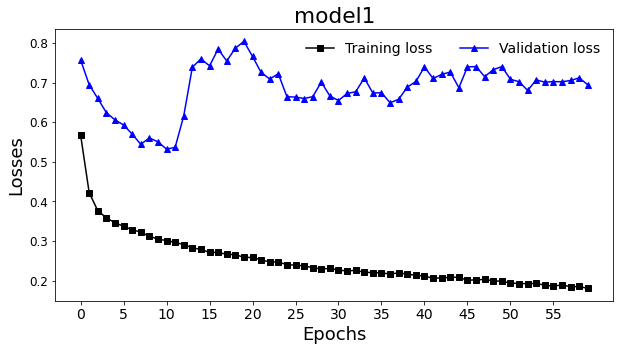

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


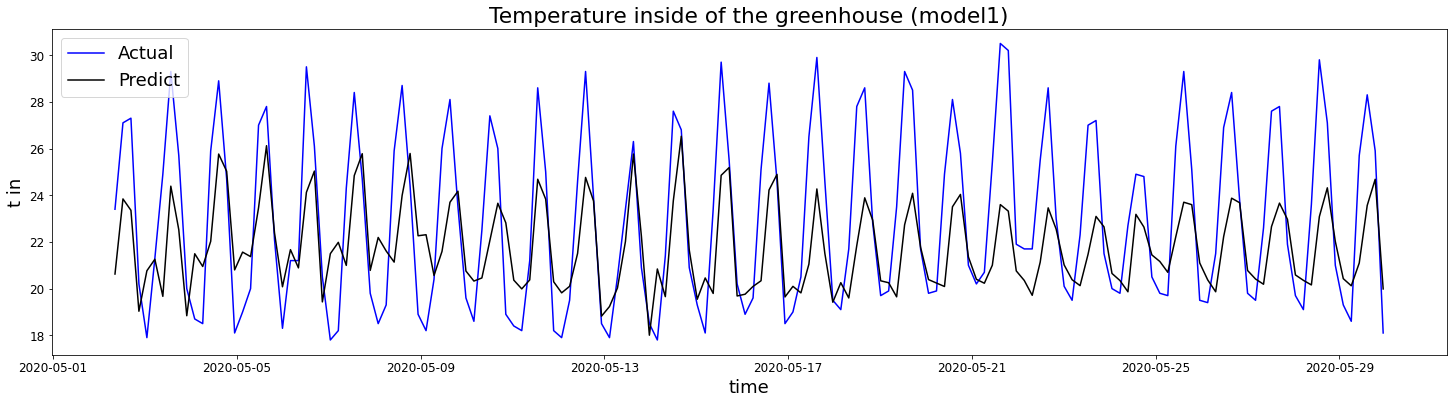




63/63 [==============================] - 1s 8ms/step - loss: 1.0047


In [ ]:
greenhouse_temp_pred(name="model1", units=32, dropout=0, optimizer=RMSprop, loss="mae", epochs=60)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 32)                5120      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5,153
Trainable params: 5,153
Non-trainable params: 0
_________________________________________________________________



Epoch 1/60
215/220 [============================>.] - ETA: 0s - loss: 0.6353

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 9s 30ms/step - loss: 0.6332 - val_loss: 0.8627
Epoch 2/60
219/220 [============================>.] - ETA: 0s - loss: 0.4564

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 6s 29ms/step - loss: 0.4559 - val_loss: 0.7132
Epoch 3/60
220/220 [==============================] - ETA: 0s - loss: 0.3902

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 7s 30ms/step - loss: 0.3902 - val_loss: 0.6102
Epoch 4/60
219/220 [============================>.] - ETA: 0s - loss: 0.3716

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 6s 29ms/step - loss: 0.3710 - val_loss: 0.5527
Epoch 5/60
216/220 [============================>.] - ETA: 0s - loss: 0.3513

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 7s 31ms/step - loss: 0.3493 - val_loss: 0.5120
Epoch 6/60
220/220 [==============================] - 3s 13ms/step - loss: 0.3369 - val_loss: 0.5423
Epoch 7/60
220/220 [==============================] - 3s 12ms/step - loss: 0.3235 - val_loss: 0.6605
Epoch 8/60
220/220 [==============================] - 3s 13ms/step - loss: 0.3205 - val_loss: 0.5649
Epoch 9/60
220/220 [==============================] - 3s 13ms/step - loss: 0.3149 - val_loss: 0.6986
Epoch 10/60
219/220 [============================>.] - ETA: 0s - loss: 0.3106

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 6s 29ms/step - loss: 0.3108 - val_loss: 0.4748
Epoch 11/60
220/220 [==============================] - 3s 13ms/step - loss: 0.3011 - val_loss: 0.5381
Epoch 12/60
220/220 [==============================] - 3s 13ms/step - loss: 0.2941 - val_loss: 0.5446
Epoch 13/60
220/220 [==============================] - 3s 12ms/step - loss: 0.2898 - val_loss: 0.5528
Epoch 14/60
220/220 [==============================] - 3s 12ms/step - loss: 0.2799 - val_loss: 0.6334
Epoch 15/60
220/220 [==============================] - 3s 13ms/step - loss: 0.2781 - val_loss: 0.5929
Epoch 16/60
220/220 [==============================] - 3s 12ms/step - loss: 0.2760 - val_loss: 0.6674
Epoch 17/60
220/220 [==============================] - 3s 12ms/step - loss: 0.2717 - val_loss: 0.6183
Epoch 18/60
220/220 [==============================] - 3s 12ms/step - loss: 0.2711 - val_loss: 0.6663
Epoch 19/60
220/220 [==============================] - 3s 12ms/step - loss: 0.2638 - val_loss:

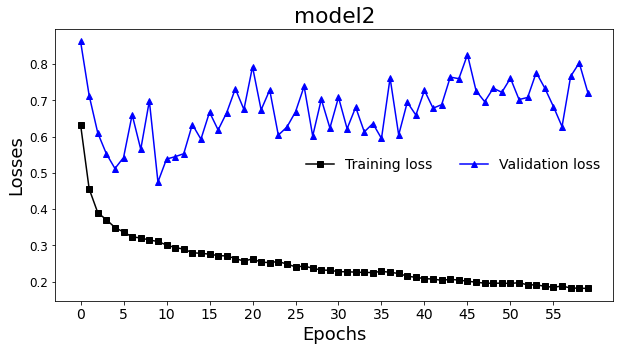

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


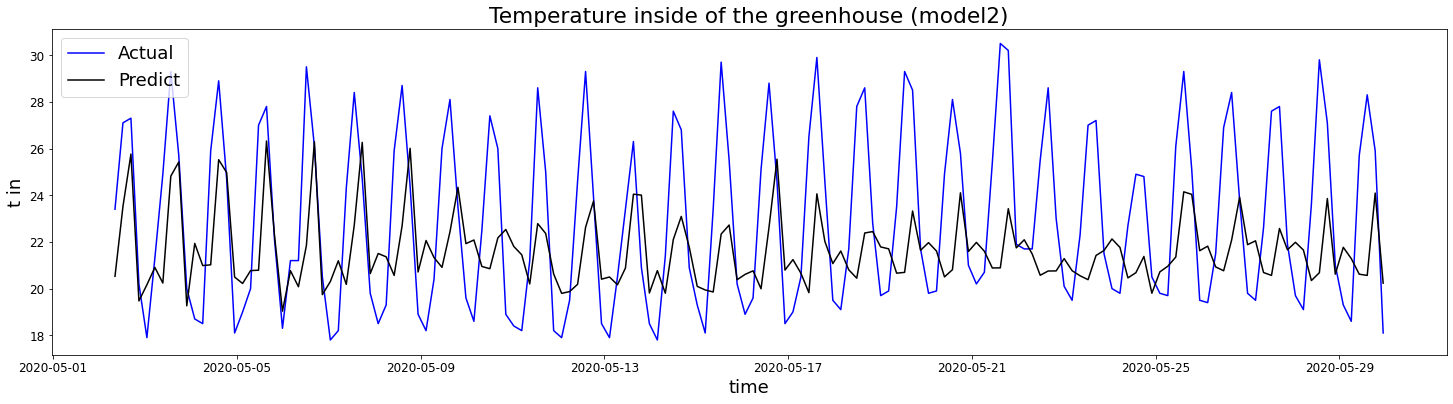




63/63 [==============================] - 1s 8ms/step - loss: 1.2226


In [ ]:
greenhouse_temp_pred(name="model2", units=32, dropout=0, optimizer=Adam, loss="mae", epochs=60)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 32)                5120      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5,153
Trainable params: 5,153
Non-trainable params: 0
_________________________________________________________________



Epoch 1/60
220/220 [==============================] - ETA: 0s - loss: 0.6339

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 9s 33ms/step - loss: 0.6339 - val_loss: 0.9857
Epoch 2/60
217/220 [============================>.] - ETA: 0s - loss: 0.3903

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 7s 31ms/step - loss: 0.3868 - val_loss: 0.8749
Epoch 3/60
218/220 [============================>.] - ETA: 0s - loss: 0.2754

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 6s 28ms/step - loss: 0.2743 - val_loss: 0.6776
Epoch 4/60
217/220 [============================>.] - ETA: 0s - loss: 0.2401

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 7s 30ms/step - loss: 0.2384 - val_loss: 0.5606
Epoch 5/60
218/220 [============================>.] - ETA: 0s - loss: 0.2141

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 7s 30ms/step - loss: 0.2128 - val_loss: 0.4861
Epoch 6/60
218/220 [============================>.] - ETA: 0s - loss: 0.2023

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 6s 29ms/step - loss: 0.2016 - val_loss: 0.4786
Epoch 7/60
220/220 [==============================] - 3s 13ms/step - loss: 0.1902 - val_loss: 0.4929
Epoch 8/60
220/220 [==============================] - 3s 13ms/step - loss: 0.1860 - val_loss: 0.5090
Epoch 9/60
220/220 [==============================] - 3s 13ms/step - loss: 0.1693 - val_loss: 0.5424
Epoch 10/60
220/220 [==============================] - 3s 13ms/step - loss: 0.1642 - val_loss: 0.6520
Epoch 11/60
220/220 [==============================] - 3s 13ms/step - loss: 0.1545 - val_loss: 0.6842
Epoch 12/60
220/220 [==============================] - 3s 12ms/step - loss: 0.1533 - val_loss: 0.8833
Epoch 13/60
220/220 [==============================] - 3s 16ms/step - loss: 0.1472 - val_loss: 0.8009
Epoch 14/60
220/220 [==============================] - 4s 17ms/step - loss: 0.1559 - val_loss: 0.9164
Epoch 15/60
220/220 [==============================] - 3s 13ms/step - loss: 0.1362 - val_loss: 0.

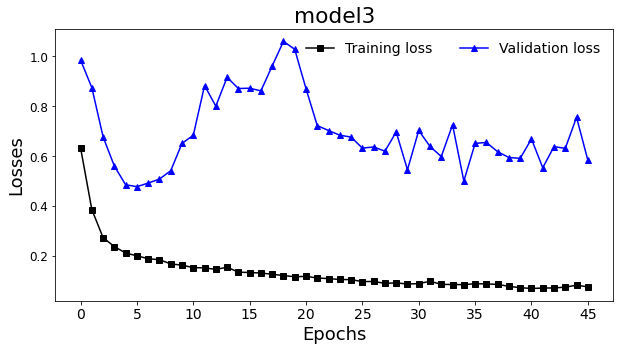

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


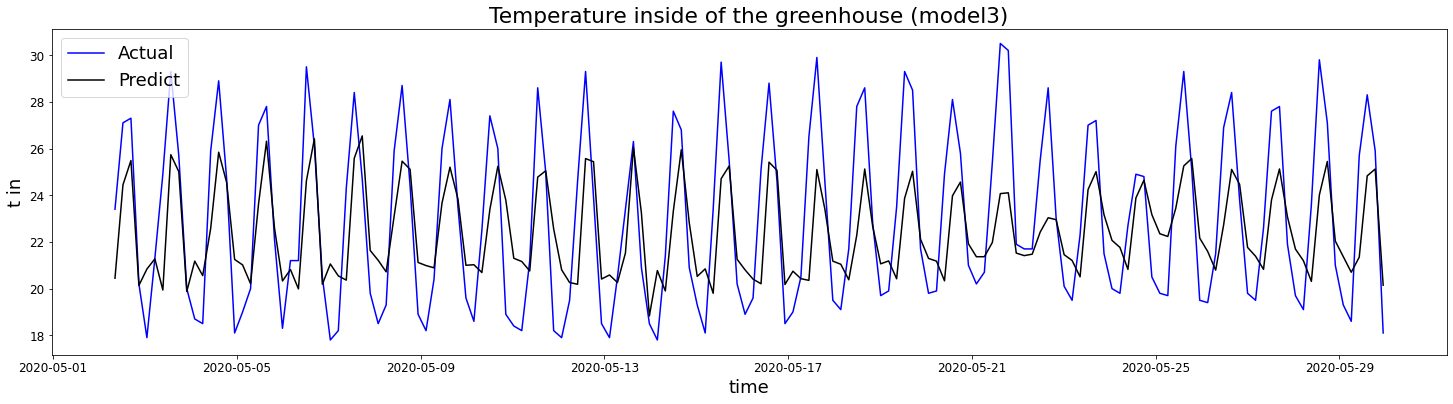




63/63 [==============================] - 1s 8ms/step - loss: 1.2816


In [ ]:
greenhouse_temp_pred(name="model3", units=32, dropout=0, optimizer=Adam, loss="mse", epochs=60)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 10)                720       
                                                                 
 dense_4 (Dense)             (None, 1)                 11        
                                                                 
Total params: 731
Trainable params: 731
Non-trainable params: 0
_________________________________________________________________



Epoch 1/60
219/220 [============================>.] - ETA: 0s - loss: 0.7205

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 9s 33ms/step - loss: 0.7186 - val_loss: 1.1297
Epoch 2/60
216/220 [============================>.] - ETA: 0s - loss: 0.6266

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 6s 29ms/step - loss: 0.6228 - val_loss: 1.0001
Epoch 3/60
219/220 [============================>.] - ETA: 0s - loss: 0.5783

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 7s 32ms/step - loss: 0.5772 - val_loss: 0.9146
Epoch 4/60
216/220 [============================>.] - ETA: 0s - loss: 0.5300

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 7s 31ms/step - loss: 0.5270 - val_loss: 0.8612
Epoch 5/60
217/220 [============================>.] - ETA: 0s - loss: 0.4859

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 7s 30ms/step - loss: 0.4835 - val_loss: 0.8542
Epoch 6/60
220/220 [==============================] - 3s 13ms/step - loss: 0.4548 - val_loss: 0.8769
Epoch 7/60
220/220 [==============================] - 3s 14ms/step - loss: 0.4322 - val_loss: 0.8962
Epoch 8/60
220/220 [==============================] - 3s 13ms/step - loss: 0.4136 - val_loss: 0.9095
Epoch 9/60
220/220 [==============================] - 3s 12ms/step - loss: 0.3980 - val_loss: 0.9114
Epoch 10/60
220/220 [==============================] - 3s 13ms/step - loss: 0.3869 - val_loss: 0.8961
Epoch 11/60
220/220 [==============================] - 3s 12ms/step - loss: 0.3820 - val_loss: 0.8840
Epoch 12/60
220/220 [==============================] - 3s 14ms/step - loss: 0.3754 - val_loss: 0.8573
Epoch 13/60
220/220 [==============================] - 3s 13ms/step - loss: 0.3660 - val_loss: 0.8654
Epoch 14/60
219/220 [============================>.] - ETA: 0s - loss: 0.3603

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 7s 31ms/step - loss: 0.3597 - val_loss: 0.8498
Epoch 15/60
218/220 [============================>.] - ETA: 0s - loss: 0.3559

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 6s 29ms/step - loss: 0.3552 - val_loss: 0.8458
Epoch 16/60
218/220 [============================>.] - ETA: 0s - loss: 0.3494

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 7s 31ms/step - loss: 0.3492 - val_loss: 0.8377
Epoch 17/60
220/220 [==============================] - 3s 14ms/step - loss: 0.3483 - val_loss: 0.8402
Epoch 18/60
220/220 [==============================] - ETA: 0s - loss: 0.3489

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 7s 30ms/step - loss: 0.3489 - val_loss: 0.8361
Epoch 19/60
219/220 [============================>.] - ETA: 0s - loss: 0.3470

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 6s 29ms/step - loss: 0.3468 - val_loss: 0.8228
Epoch 20/60
216/220 [============================>.] - ETA: 0s - loss: 0.3394

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 8s 35ms/step - loss: 0.3392 - val_loss: 0.8154
Epoch 21/60
220/220 [==============================] - 3s 13ms/step - loss: 0.3377 - val_loss: 0.8331
Epoch 22/60
220/220 [==============================] - 3s 13ms/step - loss: 0.3350 - val_loss: 0.8329
Epoch 23/60
220/220 [==============================] - 3s 13ms/step - loss: 0.3277 - val_loss: 0.8468
Epoch 24/60
220/220 [==============================] - 3s 13ms/step - loss: 0.3271 - val_loss: 0.8402
Epoch 25/60
217/220 [============================>.] - ETA: 0s - loss: 0.3268

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 7s 31ms/step - loss: 0.3259 - val_loss: 0.7947
Epoch 26/60
216/220 [============================>.] - ETA: 0s - loss: 0.3284

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 7s 32ms/step - loss: 0.3292 - val_loss: 0.7595
Epoch 27/60
216/220 [============================>.] - ETA: 0s - loss: 0.3214

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 7s 31ms/step - loss: 0.3240 - val_loss: 0.7350
Epoch 28/60
217/220 [============================>.] - ETA: 0s - loss: 0.3202

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 7s 30ms/step - loss: 0.3194 - val_loss: 0.7186
Epoch 29/60
219/220 [============================>.] - ETA: 0s - loss: 0.3160

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 7s 32ms/step - loss: 0.3156 - val_loss: 0.7066
Epoch 30/60
220/220 [==============================] - ETA: 0s - loss: 0.3131

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 7s 30ms/step - loss: 0.3131 - val_loss: 0.6934
Epoch 31/60
219/220 [============================>.] - ETA: 0s - loss: 0.3108

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 7s 32ms/step - loss: 0.3105 - val_loss: 0.6852
Epoch 32/60
220/220 [==============================] - ETA: 0s - loss: 0.3087

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 7s 31ms/step - loss: 0.3087 - val_loss: 0.6751
Epoch 33/60
220/220 [==============================] - 3s 13ms/step - loss: 0.3082 - val_loss: 0.6787
Epoch 34/60
220/220 [==============================] - 3s 13ms/step - loss: 0.3090 - val_loss: 0.6843
Epoch 35/60
216/220 [============================>.] - ETA: 0s - loss: 0.3084

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 6s 29ms/step - loss: 0.3082 - val_loss: 0.6660
Epoch 36/60
220/220 [==============================] - 3s 13ms/step - loss: 0.3137 - val_loss: 0.6765
Epoch 37/60
220/220 [==============================] - 3s 13ms/step - loss: 0.3057 - val_loss: 0.6731
Epoch 38/60
220/220 [==============================] - 3s 13ms/step - loss: 0.3087 - val_loss: 0.6677
Epoch 39/60
217/220 [============================>.] - ETA: 0s - loss: 0.3039

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 7s 32ms/step - loss: 0.3032 - val_loss: 0.6597
Epoch 40/60
220/220 [==============================] - 3s 13ms/step - loss: 0.3011 - val_loss: 0.6628
Epoch 41/60
220/220 [==============================] - 3s 13ms/step - loss: 0.2975 - val_loss: 0.6607
Epoch 42/60
220/220 [==============================] - 3s 13ms/step - loss: 0.2979 - val_loss: 0.6720
Epoch 43/60
220/220 [==============================] - 3s 13ms/step - loss: 0.2955 - val_loss: 0.6806
Epoch 44/60
220/220 [==============================] - 3s 13ms/step - loss: 0.2998 - val_loss: 0.6790
Epoch 45/60
220/220 [==============================] - 3s 13ms/step - loss: 0.2960 - val_loss: 0.7180
Epoch 46/60
220/220 [==============================] - 3s 13ms/step - loss: 0.2945 - val_loss: 0.7170
Epoch 47/60
220/220 [==============================] - 3s 13ms/step - loss: 0.2941 - val_loss: 0.7208
Epoch 48/60
220/220 [==============================] - 3s 13ms/step - loss: 0.2928 - val_loss:

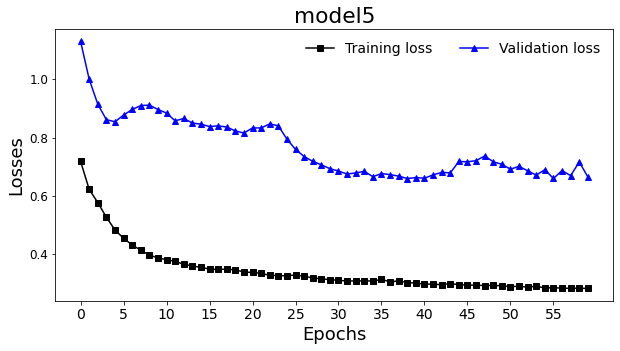

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


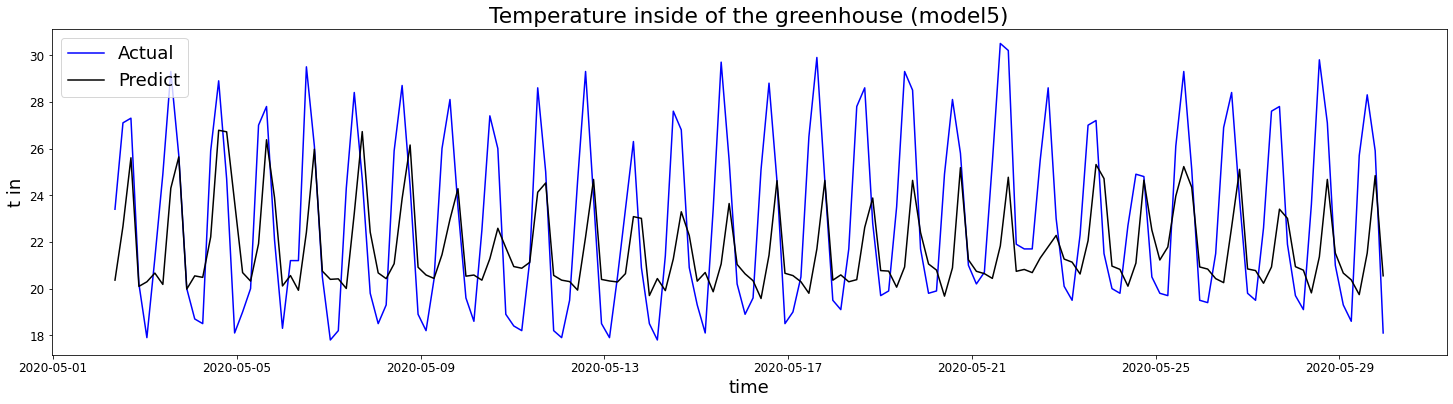




63/63 [==============================] - 1s 8ms/step - loss: 1.1405


In [ ]:
greenhouse_temp_pred(name="model5", units=10, dropout=0.2, optimizer=Adam, loss="mae", epochs=60)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 32)                5120      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5,153
Trainable params: 5,153
Non-trainable params: 0
_________________________________________________________________



Epoch 1/60
219/220 [============================>.] - ETA: 0s - loss: 0.6285

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 10s 39ms/step - loss: 0.6270 - val_loss: 0.8992
Epoch 2/60
217/220 [============================>.] - ETA: 0s - loss: 0.4532

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 7s 31ms/step - loss: 0.4509 - val_loss: 0.8292
Epoch 3/60
217/220 [============================>.] - ETA: 0s - loss: 0.4082

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 7s 31ms/step - loss: 0.4058 - val_loss: 0.7597
Epoch 4/60
218/220 [============================>.] - ETA: 0s - loss: 0.3862

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 7s 30ms/step - loss: 0.3858 - val_loss: 0.6255
Epoch 5/60
218/220 [============================>.] - ETA: 0s - loss: 0.3658

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 7s 32ms/step - loss: 0.3644 - val_loss: 0.5880
Epoch 6/60
220/220 [==============================] - ETA: 0s - loss: 0.3524

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 7s 30ms/step - loss: 0.3524 - val_loss: 0.5266
Epoch 7/60
217/220 [============================>.] - ETA: 0s - loss: 0.3452

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 7s 32ms/step - loss: 0.3441 - val_loss: 0.5175
Epoch 8/60
220/220 [==============================] - 3s 13ms/step - loss: 0.3388 - val_loss: 0.5197
Epoch 9/60
220/220 [==============================] - 3s 12ms/step - loss: 0.3236 - val_loss: 0.5336
Epoch 10/60
220/220 [==============================] - 3s 13ms/step - loss: 0.3209 - val_loss: 0.6033
Epoch 11/60
220/220 [==============================] - 3s 12ms/step - loss: 0.3192 - val_loss: 0.6572
Epoch 12/60
220/220 [==============================] - 3s 13ms/step - loss: 0.3156 - val_loss: 0.5971
Epoch 13/60
220/220 [==============================] - 3s 13ms/step - loss: 0.3082 - val_loss: 0.5411
Epoch 14/60
220/220 [==============================] - 3s 13ms/step - loss: 0.3050 - val_loss: 0.5230
Epoch 15/60
220/220 [==============================] - 3s 13ms/step - loss: 0.2978 - val_loss: 0.6437
Epoch 16/60
220/220 [==============================] - 3s 12ms/step - loss: 0.2942 - val_loss: 0

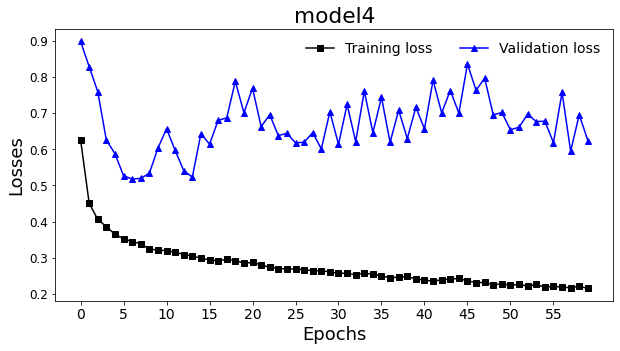

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


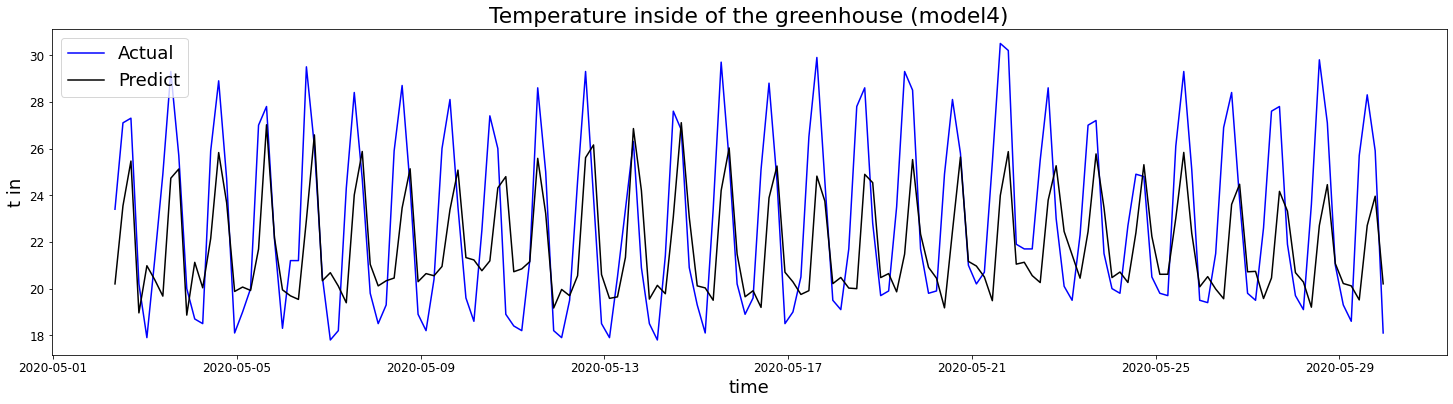




63/63 [==============================] - 0s 8ms/step - loss: 1.0370


In [ ]:
greenhouse_temp_pred(name="model4", units=32, dropout=0.2, optimizer=Adam, loss="mae", epochs=60)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 4)                 192       
                                                                 
 dense_5 (Dense)             (None, 1)                 5         
                                                                 
Total params: 197
Trainable params: 197
Non-trainable params: 0
_________________________________________________________________



Epoch 1/60
220/220 [==============================] - ETA: 0s - loss: 0.7919

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 9s 32ms/step - loss: 0.7919 - val_loss: 1.2211
Epoch 2/60
220/220 [==============================] - ETA: 0s - loss: 0.6749

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 6s 29ms/step - loss: 0.6749 - val_loss: 1.1904
Epoch 3/60
219/220 [============================>.] - ETA: 0s - loss: 0.6289

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 7s 30ms/step - loss: 0.6272 - val_loss: 1.1625
Epoch 4/60
215/220 [============================>.] - ETA: 0s - loss: 0.5964

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 7s 30ms/step - loss: 0.5898 - val_loss: 1.1376
Epoch 5/60
220/220 [==============================] - ETA: 0s - loss: 0.5666

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 6s 29ms/step - loss: 0.5666 - val_loss: 1.1222
Epoch 6/60
216/220 [============================>.] - ETA: 0s - loss: 0.5587

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 7s 31ms/step - loss: 0.5571 - val_loss: 1.1019
Epoch 7/60
218/220 [============================>.] - ETA: 0s - loss: 0.5454

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 7s 30ms/step - loss: 0.5444 - val_loss: 1.0803
Epoch 8/60
215/220 [============================>.] - ETA: 0s - loss: 0.5340

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 7s 32ms/step - loss: 0.5335 - val_loss: 1.0629
Epoch 9/60
218/220 [============================>.] - ETA: 0s - loss: 0.5240

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 7s 31ms/step - loss: 0.5227 - val_loss: 1.0452
Epoch 10/60
216/220 [============================>.] - ETA: 0s - loss: 0.5148

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 6s 29ms/step - loss: 0.5109 - val_loss: 1.0226
Epoch 11/60
216/220 [============================>.] - ETA: 0s - loss: 0.5084

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 7s 31ms/step - loss: 0.5087 - val_loss: 1.0077
Epoch 12/60
218/220 [============================>.] - ETA: 0s - loss: 0.5039

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 7s 31ms/step - loss: 0.5050 - val_loss: 0.9955
Epoch 13/60
220/220 [==============================] - ETA: 0s - loss: 0.4985

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 6s 29ms/step - loss: 0.4985 - val_loss: 0.9813
Epoch 14/60
220/220 [==============================] - 3s 13ms/step - loss: 0.4979 - val_loss: 0.9923
Epoch 15/60
220/220 [==============================] - 3s 13ms/step - loss: 0.4804 - val_loss: 0.9989
Epoch 16/60
220/220 [==============================] - 3s 13ms/step - loss: 0.4695 - val_loss: 0.9991
Epoch 17/60
220/220 [==============================] - 3s 13ms/step - loss: 0.4620 - val_loss: 1.0197
Epoch 18/60
220/220 [==============================] - 3s 12ms/step - loss: 0.4494 - val_loss: 1.0270
Epoch 19/60
220/220 [==============================] - 3s 13ms/step - loss: 0.4506 - val_loss: 1.0202
Epoch 20/60
220/220 [==============================] - 3s 13ms/step - loss: 0.4336 - val_loss: 1.0190
Epoch 21/60
220/220 [==============================] - 3s 13ms/step - loss: 0.4354 - val_loss: 1.0226
Epoch 22/60
220/220 [==============================] - 3s 13ms/step - loss: 0.4285 - val_loss:

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 7s 32ms/step - loss: 0.4180 - val_loss: 0.9528
Epoch 27/60
220/220 [==============================] - ETA: 0s - loss: 0.4078

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 8s 36ms/step - loss: 0.4078 - val_loss: 0.9165
Epoch 28/60
217/220 [============================>.] - ETA: 0s - loss: 0.3978

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 7s 31ms/step - loss: 0.3977 - val_loss: 0.8834
Epoch 29/60
219/220 [============================>.] - ETA: 0s - loss: 0.3933

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 6s 29ms/step - loss: 0.3927 - val_loss: 0.8629
Epoch 30/60
216/220 [============================>.] - ETA: 0s - loss: 0.3928

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 7s 31ms/step - loss: 0.3913 - val_loss: 0.8522
Epoch 31/60
217/220 [============================>.] - ETA: 0s - loss: 0.3903

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 7s 31ms/step - loss: 0.3890 - val_loss: 0.8335
Epoch 32/60
216/220 [============================>.] - ETA: 0s - loss: 0.3866

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 6s 29ms/step - loss: 0.3848 - val_loss: 0.8096
Epoch 33/60
220/220 [==============================] - ETA: 0s - loss: 0.3856

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 7s 32ms/step - loss: 0.3856 - val_loss: 0.8072
Epoch 34/60
220/220 [==============================] - ETA: 0s - loss: 0.3813

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 7s 31ms/step - loss: 0.3813 - val_loss: 0.7932
Epoch 35/60
218/220 [============================>.] - ETA: 0s - loss: 0.3819

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 7s 32ms/step - loss: 0.3807 - val_loss: 0.7847
Epoch 36/60
220/220 [==============================] - ETA: 0s - loss: 0.3787

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 7s 32ms/step - loss: 0.3787 - val_loss: 0.7788
Epoch 37/60
216/220 [============================>.] - ETA: 0s - loss: 0.3760

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 7s 30ms/step - loss: 0.3750 - val_loss: 0.7537
Epoch 38/60
217/220 [============================>.] - ETA: 0s - loss: 0.3774

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 7s 32ms/step - loss: 0.3783 - val_loss: 0.7301
Epoch 39/60
216/220 [============================>.] - ETA: 0s - loss: 0.3725

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 7s 30ms/step - loss: 0.3736 - val_loss: 0.7146
Epoch 40/60
220/220 [==============================] - 3s 13ms/step - loss: 0.3745 - val_loss: 0.7250
Epoch 41/60
220/220 [==============================] - 3s 13ms/step - loss: 0.3723 - val_loss: 0.7361
Epoch 42/60
220/220 [==============================] - 3s 13ms/step - loss: 0.3654 - val_loss: 0.7529
Epoch 43/60
220/220 [==============================] - 3s 13ms/step - loss: 0.3644 - val_loss: 0.7647
Epoch 44/60
220/220 [==============================] - 3s 13ms/step - loss: 0.3651 - val_loss: 0.7769
Epoch 45/60
220/220 [==============================] - 3s 13ms/step - loss: 0.3627 - val_loss: 0.7676
Epoch 46/60
220/220 [==============================] - 3s 13ms/step - loss: 0.3615 - val_loss: 0.7663
Epoch 47/60
220/220 [==============================] - 3s 13ms/step - loss: 0.3593 - val_loss: 0.7706
Epoch 48/60
220/220 [==============================] - 3s 13ms/step - loss: 0.3611 - val_loss:

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 7s 31ms/step - loss: 0.3520 - val_loss: 0.7117
Epoch 54/60
218/220 [============================>.] - ETA: 0s - loss: 0.3556

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 7s 31ms/step - loss: 0.3551 - val_loss: 0.6969
Epoch 55/60
220/220 [==============================] - ETA: 0s - loss: 0.3499

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 6s 29ms/step - loss: 0.3499 - val_loss: 0.6815
Epoch 56/60
220/220 [==============================] - 3s 13ms/step - loss: 0.3480 - val_loss: 0.6876
Epoch 57/60
217/220 [============================>.] - ETA: 0s - loss: 0.3469

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 8s 36ms/step - loss: 0.3464 - val_loss: 0.6791
Epoch 58/60
219/220 [============================>.] - ETA: 0s - loss: 0.3465

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 7s 30ms/step - loss: 0.3460 - val_loss: 0.6738
Epoch 59/60
219/220 [============================>.] - ETA: 0s - loss: 0.3470

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


220/220 [==============================] - 7s 32ms/step - loss: 0.3468 - val_loss: 0.6729
Epoch 60/60
220/220 [==============================] - 3s 14ms/step - loss: 0.3479 - val_loss: 0.6736





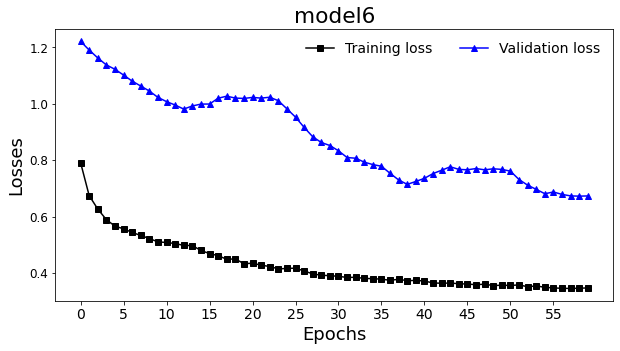

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


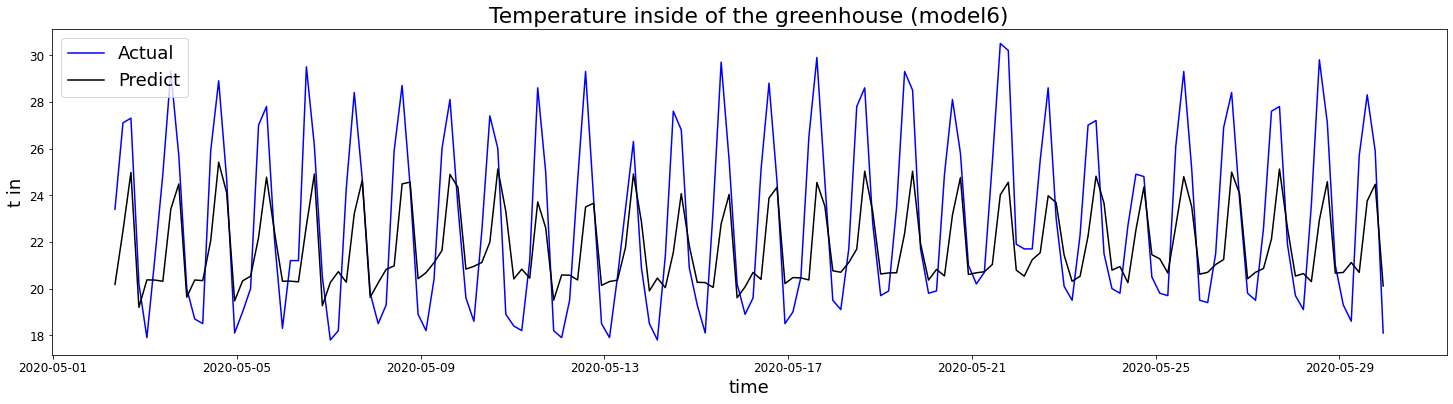




63/63 [==============================] - 1s 8ms/step - loss: 0.9948


In [ ]:
greenhouse_temp_pred(name="model6", units=4, dropout=0.2, optimizer=Adam, loss="mae", epochs=60)